In [6]:
import gc

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
import numpy as np

In [7]:
# Cuda maintenance
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)

Torch device:  cuda


# Implement image classifier for 5 classes

---

This is the second approach to the task. First we will detect and crop faces from provided samples and then
provide them into classifier.

No big improvement is expected in this case, since samples are already cropped and classifier accuracy without
image preprocessing is **0.99**.

In [8]:
# Dataset paramaters

train_data_path = '/home/rpc/Desktop/FaceRecognition/data/train'
test_data_path = '/home/rpc/Desktop/FaceRecognition/data/valid'

BATCH_SIZE = 32
WORKERS = 0
IMG_SIZE = 160

## Detect faces and crop images before fine-tuning

---

For detecting faces we will use ``MTCNN face detector`` from ``facenet_pytorch`` module (https://github.com/timesler/facenet-pytorch/blob/master/models/mtcnn.py). This model detects all faces in PIL image and return bounding boxes and probabilities as well.

Face detector is integrated into ``datasets.ImageFolder`` wrapper: https://github.com/anastasia-spb/FaceRecognition/blob/main/mtcnn_dataset_wrapper.py

The important moment in the implementation of this wrapper is that we would like to keep
the same transformation pipeline as in the first notebook. 
``MTCNN`` applies following transformations: https://github.com/timesler/facenet-pytorch/blob/master/models/utils/detect_face.py#L376 Thefore we only need to normalize resulting image. 
Also we have to set parameter ``post_process`` to False to prevent standardization.



In [9]:
from mtcnn_dataset_wrapper import MTCNNDatasetWrapper

def collate_pil_3args(x): 
    out_x, out_y, out_z = [], [], [] 
    for xx, yy, zz in x: 
        out_x.append(xx) 
        out_y.append(yy) 
        out_z.append(zz) 
    return out_x, out_y, out_z

mtcnn_dataset = MTCNNDatasetWrapper(test_data_path)

In [10]:
mtcnn_visu_loader = DataLoader(
    mtcnn_dataset,
    num_workers=0,
    batch_size=BATCH_SIZE,
    collate_fn=collate_pil_3args,
    shuffle=True
)

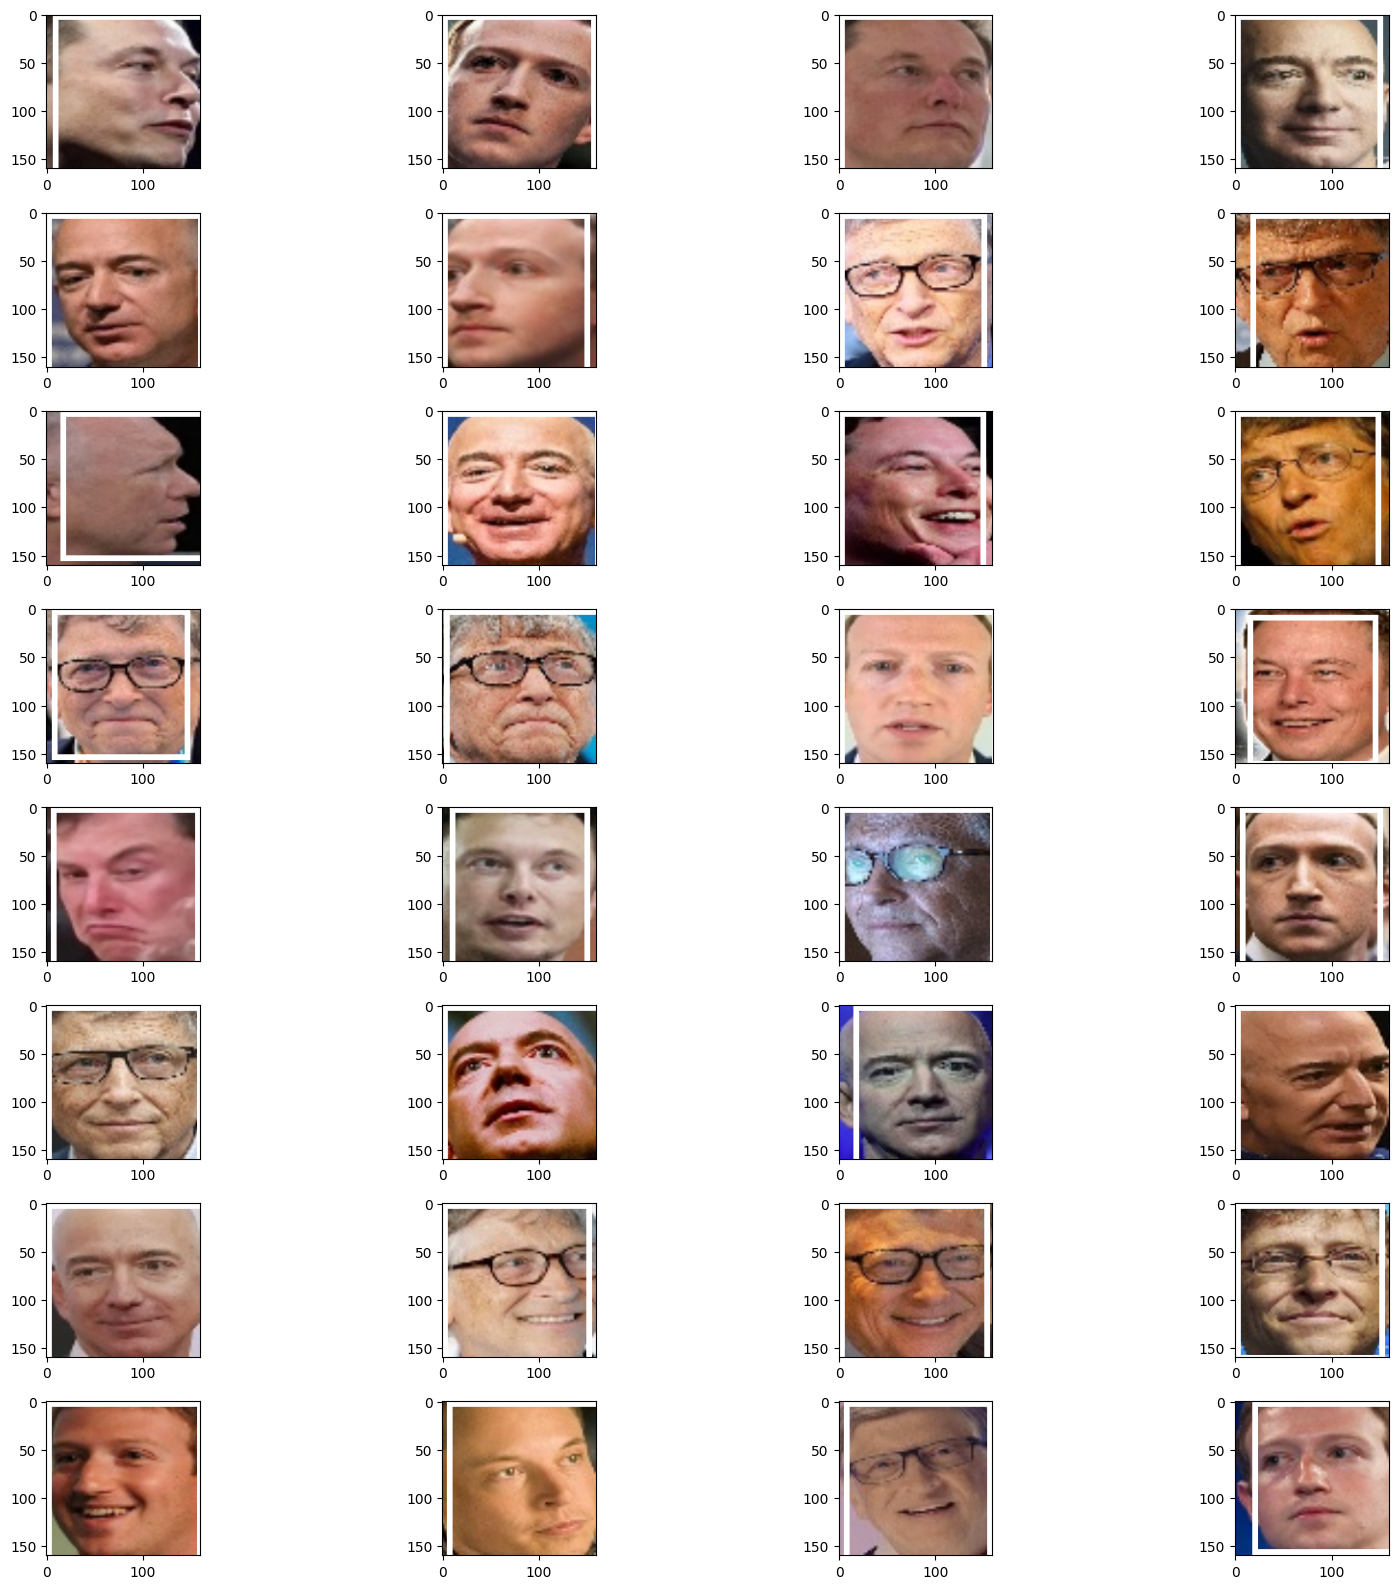

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image, ImageDraw

ncols=4
nrows=int(BATCH_SIZE/ncols)

images, _, boxes = next(iter(mtcnn_visu_loader))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(images):
            break
        img_draw = images[idx].copy()
        draw = ImageDraw.Draw(img_draw)
        if boxes[idx] is not None:
            box = [max(0.0, p) for p in boxes[idx].tolist()[0]]
            draw.rectangle(box, width=6, outline='white')
        else:
            w, h = img_draw.size
            box = [0.0, 0.0, w, h]
            draw.rectangle(box, width=6, outline='red')
        ax[i][j].imshow(img_draw)
    
plt.show()

In [12]:
# Delete loader which returns boxes instead of cropped images
del mtcnn_dataset

## Finetune pretrained model

---

Rest of the pipeline is the same as in the first notebook


In [13]:
train_dataset = MTCNNDatasetWrapper(train_data_path, device=device, return_boxes=False)

In [14]:
resnet_model = InceptionResnetV1(classify=True,
    pretrained='vggface2',
    num_classes=len(train_dataset.class_to_idx)).to(device)

In [15]:
idx_to_class = dict()

for key, value in train_dataset.class_to_idx.items():
    idx_to_class[value] = key

In [17]:
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

In [18]:
from sklearn.model_selection import train_test_split

train_idx, validation_idx = train_test_split(list(range(len(train_dataset))),
                                             test_size=0.3, random_state=42, shuffle=True)


In [19]:
train_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(train_idx)
)

val_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(validation_idx)
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [21]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

EPOCHS = 8


print('\nBefore fine-tuning')
print('-' * 10)
resnet_model.eval()
training.pass_epoch(
    resnet_model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(EPOCHS):
    print('\nEpoch {}/{}'.format(epoch + 1, EPOCHS))
    print('-' * 10)

    resnet_model.train()
    training.pass_epoch(
        resnet_model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_model.eval()
    training.pass_epoch(
        resnet_model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()


Before fine-tuning
----------
Valid |    29/29   | loss:    1.6318 | fps:   73.4394 | acc:    0.2651   

Epoch 1/8
----------
Train |    66/66   | loss:    0.3706 | fps:   65.9833 | acc:    0.8813   
Valid |    29/29   | loss:    0.3287 | fps:   77.6955 | acc:    0.9095   

Epoch 2/8
----------
Train |    66/66   | loss:    0.1121 | fps:   67.7497 | acc:    0.9614   
Valid |    29/29   | loss:    0.1188 | fps:   77.8210 | acc:    0.9731   

Epoch 3/8
----------
Train |    66/66   | loss:    0.0975 | fps:   67.6001 | acc:    0.9683   
Valid |    29/29   | loss:    0.1339 | fps:   77.8269 | acc:    0.9666   

Epoch 4/8
----------
Train |    66/66   | loss:    0.0874 | fps:   67.6826 | acc:    0.9692   
Valid |    29/29   | loss:    0.1175 | fps:   77.1790 | acc:    0.9634   

Epoch 5/8
----------
Train |    66/66   | loss:    0.0659 | fps:   66.4335 | acc:    0.9794   
Valid |    29/29   | loss:    0.0843 | fps:   76.3514 | acc:    0.9838   

Epoch 6/8
----------
Train |    66/66   | lo

In [22]:
test_dataset = MTCNNDatasetWrapper(test_data_path, device=device, return_boxes=False)

test_loader = DataLoader(
    test_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE
)

In [23]:
resnet_model.eval()

y_true = []
y_predicted = []

misclassified_img = []

for batch_idx, (x, y) in enumerate(test_loader):
    scores = resnet_model(x.cuda())
    softmax = torch.exp(scores).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    y_true.append(y.data)
    y_predicted.append(predictions)
    diff = [y1 - y2 for y1, y2 in zip(y.data, predictions)]
    misclassified = [i for i, e in enumerate(diff) if e != 0]
    for idx in misclassified:
        misclassified_img.append((x[idx], predictions[idx], y.data[idx]))

In [24]:
y_true = [item for sublist in y_true for item in sublist]
y_predicted = [item for sublist in y_predicted for item in sublist]

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


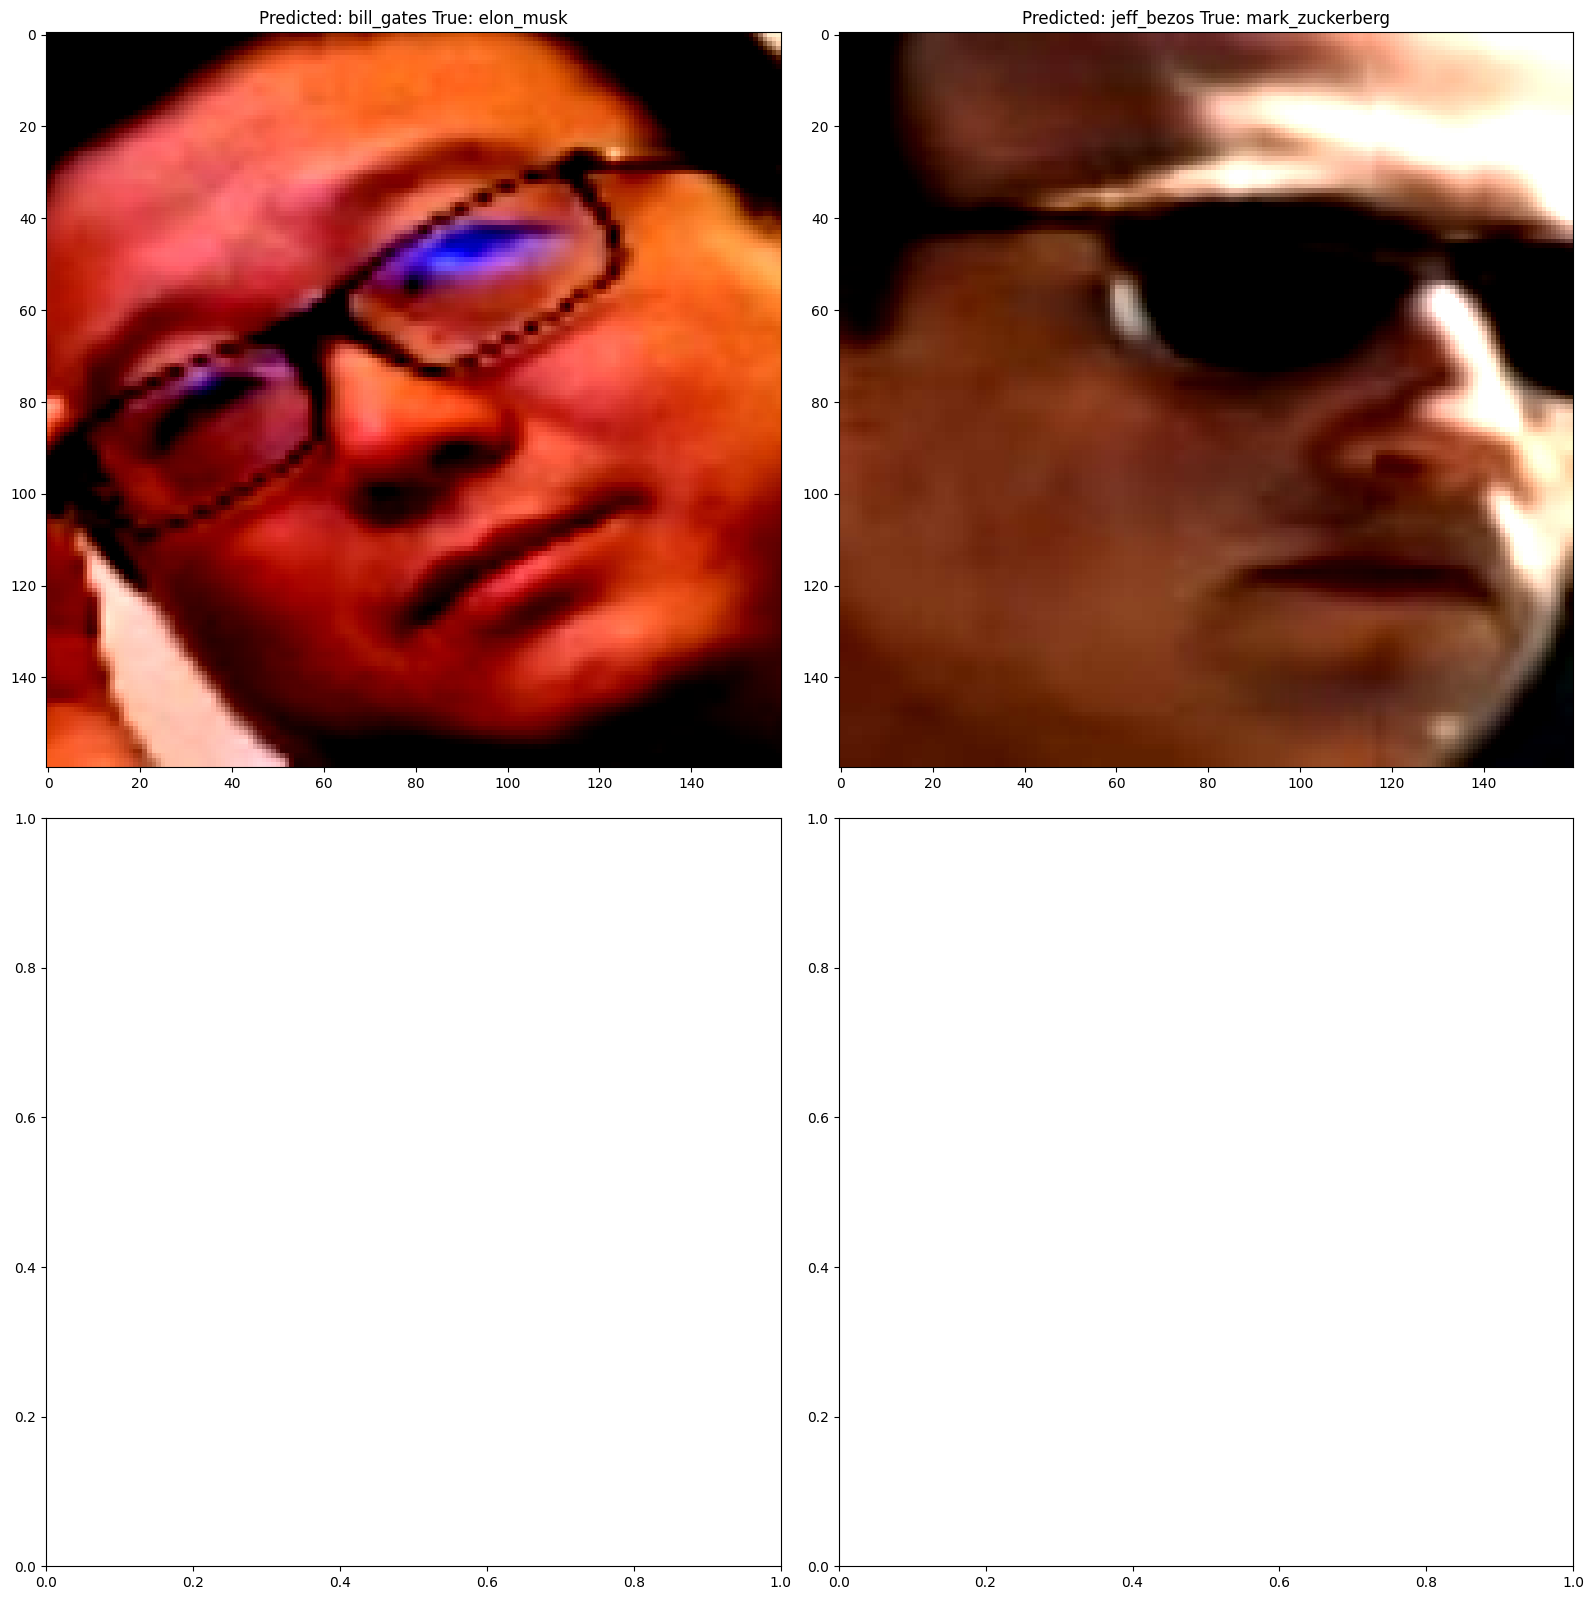

In [40]:
import math

ncols=2
nrows=max(2, math.ceil(len(misclassified_img)/ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

denormalize = transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                std = [ 1., 1., 1. ])

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(misclassified_img):
            break
        img = denormalize(misclassified_img[idx][0]).permute(1, 2, 0)
        ax[i][j].imshow(img)
        predicted_label = idx_to_class[misclassified_img[idx][1]]
        true_label = idx_to_class[misclassified_img[idx][2].item()]
        ax[i][j].set_title("Predicted: "+predicted_label+" True: "+true_label)
    
plt.show()

Accuracy: 0.9978118161925602


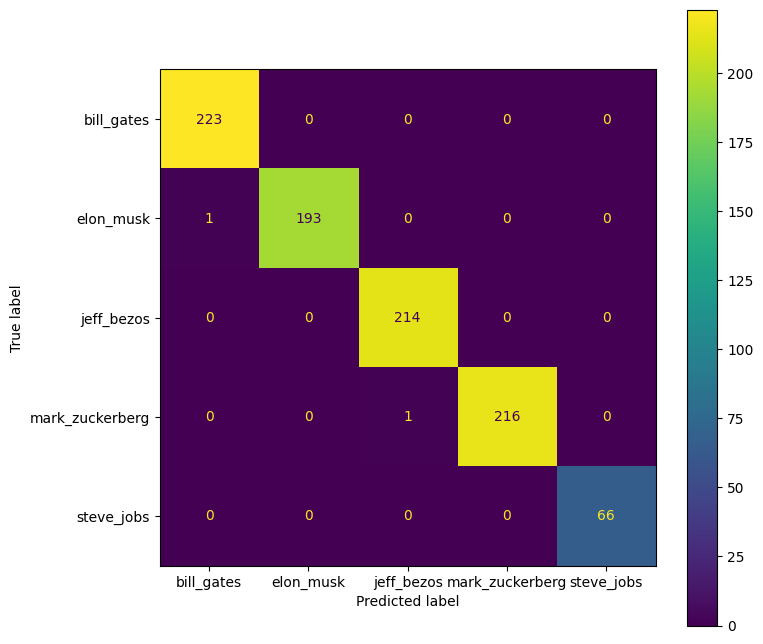

In [27]:
from sklearn import metrics 
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_predicted)
print("Accuracy: " + str(accuracy))

confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = list(train_dataset.class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8,8))

cm_display.plot(ax=ax)
plt.show()

### Summary

---

Face detection improved result and reduced misclassified images from 6 to 2 (from 5 to 1 actually, since one is a wrong sample). It also demonstrates that presence of glasses (or probably any other face covering objects) makes
classification task much harder.